In [57]:
#importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

In [58]:
#importing data and reading it
telangana_fires_data = pd.read_csv("/content/telangana_fires.csv")
telangana_areas_data = pd.read_csv("/content/telangana_areas.csv")

In [59]:
#reassigning a shorter name to ease of use
fire_data = telangana_fires_data
area_data = telangana_areas_data

In [60]:
fire_data.head(3)

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
0,18.3777,80.5314,318.6,1.0,1.0,2015-01-02,802,Aqua,MODIS,69,6.03,302.6,7.7,D,0
1,17.5898,80.9893,315.4,1.2,1.1,2015-01-04,750,Aqua,MODIS,59,6.03,299.5,8.8,D,0
2,17.6028,81.1612,311.8,1.2,1.1,2015-01-05,527,Terra,MODIS,46,6.03,299.8,6.0,D,0


In [61]:
area_data.head(3)

,Id,adm_name,Latitude,Longitude
0,1,Adilabad,19.616667,78.5
1,2,Hyderabad,17.333333,78.5
2,3,Karimnagar,18.466667,79.1


In [62]:
#converting dates into years
fire_data["year"] = pd.DatetimeIndex(fire_data["acq_date"]).year
fire_data = fire_data.drop("acq_date", axis = 1)
fire_data.head(3)

,latitude,longitude,brightness,scan,track,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type,year
0,18.3777,80.5314,318.6,1.0,1.0,802,Aqua,MODIS,69,6.03,302.6,7.7,D,0,2015
1,17.5898,80.9893,315.4,1.2,1.1,750,Aqua,MODIS,59,6.03,299.5,8.8,D,0,2015
2,17.6028,81.1612,311.8,1.2,1.1,527,Terra,MODIS,46,6.03,299.8,6.0,D,0,2015


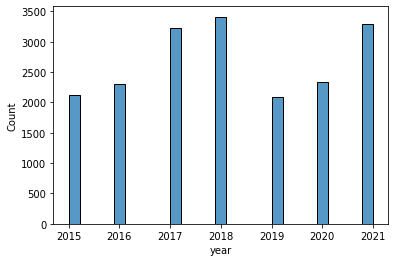

In [63]:
#plot for fires per year
sns.histplot(data = fire_data, x = "year")

We see that Cases of fire are increasing from 2015 to 2018. 
While we saw a drop into 2019, only to see a rise in 2020 and 2021 from the levels observed in 2019. 

There's a chance that cases might have been recorded low or there were less acts of planned fires during the Pandemic, Covid 19.

## Finding Boundary areas. 
To match the areas from latitudes and longitudes, I will try to find the closest District coordinates I could find at https://www.mapsofindia.com/lat_long/telangana/
by subtracting the area's coordinates by available district coordinates. 

Note: There are better approaches available that can be thought but we are short on time so, This is conveneint.

In [64]:
list_fire = fire_data.values.tolist()
list_area = area_data.values.tolist()

In [65]:
list_fire[0]

[18.3777,
 80.5314,
 318.6,
 1.0,
 1.0,
 802,
 'Aqua',
 'MODIS',
 69,
 6.03,
 302.6,
 7.7,
 'D',
 0,
 2015]

In [66]:
list_area[0]

[1, 'Adilabad', 19.61666667, 78.5]

In [67]:
print("Index of Latitude: 0 and Index of Longitude: 1 in list_fire")
print("Index of Latitude: 2 and Index of Longitude: 3 in list_area")

Index of Latitude: 0 and Index of Longitude: 1 in list_fire
Index of Latitude: 2 and Index of Longitude: 3 in list_area


In [68]:
import math
def get_area(val):
  min = 100000
  res = ""
  for area in list_area:
    #print(area[2], area[3])
    lat_diff = abs((area[2] - val[0])**2)
    long_diff = abs((area[3] - val[1])**2)
    #print(lat_diff+long_diff, min, lat_diff+long_diff > min)
    if lat_diff+ long_diff <= min:
      res = area[1]
      min = lat_diff + long_diff
      print(res)
  return res

In [69]:
fire_area_list = list() 
for fire_area in list_fire:
  #print(fire_area[0], fire_area[1])
  #get_area(fire_area)
  fire_area_list.append(get_area(fire_area))
print("Added areas")

Streaming output truncated to the last 5000 lines.
Karimnagar
Adilabad
Hyderabad
Mahbubnagar
Nalgonda
Adilabad
Hyderabad
Mahbubnagar
Nalgonda
Adilabad
Hyderabad
Mahbubnagar
Nalgonda
Adilabad
Hyderabad
Mahbubnagar
Adilabad
Karimnagar
Medak
Nizamabad
Adilabad
Karimnagar
Khammam
Warangal
Adilabad
Hyderabad
Karimnagar
Khammam
Adilabad
Hyderabad
Karimnagar
Khammam
Adilabad
Hyderabad
Karimnagar
Khammam
Adilabad
Hyderabad
Karimnagar
Khammam
Adilabad
Hyderabad
Karimnagar
Khammam
Adilabad
Hyderabad
Karimnagar
Khammam
Adilabad
Hyderabad
Karimnagar
Khammam
Adilabad
Hyderabad
Karimnagar
Khammam
Adilabad
Hyderabad
Karimnagar
Khammam
Adilabad
Adilabad
Adilabad
Adilabad
Adilabad
Adilabad
Adilabad
Adilabad
Karimnagar
Adilabad
Karimnagar
Adilabad
Adilabad
Adilabad
Adilabad
Adilabad
Adilabad
Adilabad
Karimnagar
Adilabad
Adilabad
Hyderabad
Karimnagar
Khammam
Warangal
Adilabad
Hyderabad
Karimnagar
Khammam
Adilabad
Hyderabad
Karimnagar
Khammam
Adilabad
Hyderabad
Karimnagar
Khammam
Adilabad
Hyderabad
Karimn

In [70]:
fire_area_merged = fire_data
fire_area_merged["area"] = pd.DataFrame(fire_area_list)

In [71]:
fire_area_merged.head(3)

,latitude,longitude,brightness,scan,track,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type,year,area
0,18.3777,80.5314,318.6,1.0,1.0,802,Aqua,MODIS,69,6.03,302.6,7.7,D,0,2015,Warangal
1,17.5898,80.9893,315.4,1.2,1.1,750,Aqua,MODIS,59,6.03,299.5,8.8,D,0,2015,Khammam
2,17.6028,81.1612,311.8,1.2,1.1,527,Terra,MODIS,46,6.03,299.8,6.0,D,0,2015,Khammam


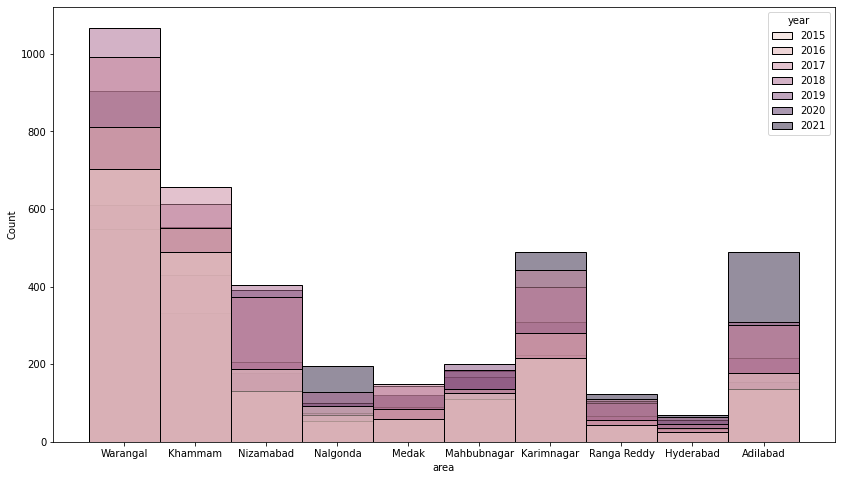

In [72]:
plt.figure(figsize = (14,8))
sns.histplot(data = fire_area_merged, x = "area" , hue = "year")

In [73]:
fire_area_merged = fire_area_merged.groupby(["area", "year"]).size()

In [76]:
fire_area_merged.columns = ['adm_name', 'year', 'fireCount']
fire_area_merged = fire_area_merged.reset_index()

In [78]:
fire_area_merged = fire_area_merged.drop("index", axis = 1)

In [79]:
fire_area_merged

,adm_name,year,fireCount
0,Adilabad,2015,178
1,Adilabad,2016,137
2,Adilabad,2017,300
3,Adilabad,2018,309
4,Adilabad,2019,215
...,...,...,...
65,Warangal,2017,991
66,Warangal,2018,1067
67,Warangal,2019,548
68,Warangal,2020,610


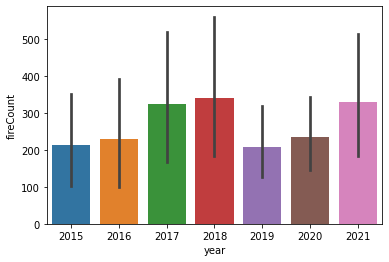

In [86]:
sns.barplot(data = fire_area_merged, y = "fireCount" , x = "year")

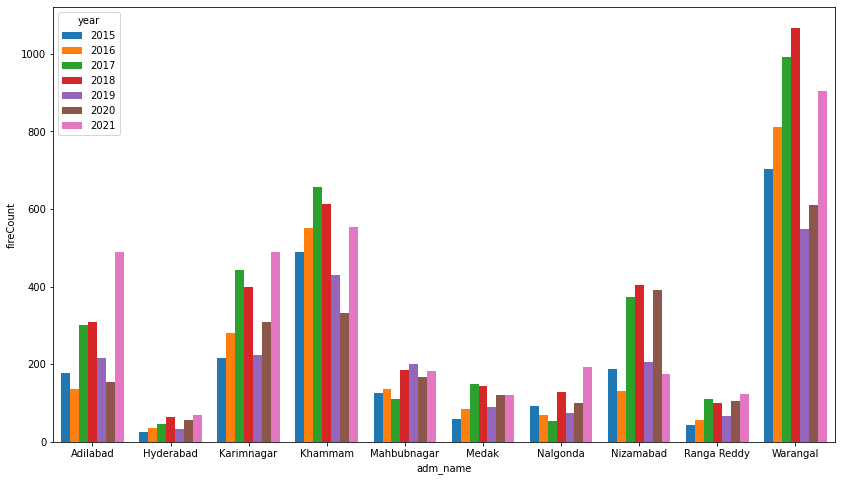

In [100]:
plt.figure(figsize = (14,8))
sns.barplot(data = fire_area_merged, x = "adm_name" , y = "fireCount" , hue = "year", saturation= 1.2)

In [104]:
import json
fire_area_merged.to_json(r'/content/Task1_json.json', orient = 'split')